In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from math import ceil,sin,cos, atan2, pi, sqrt
import pandas as pd
from cartopy import crs, feature
import requests
from bs4 import BeautifulSoup

In [48]:
import geocoder # pip install geocoder
def locat_coord(Name,province):
    g = geocoder.bing(Name+' '+province, key=APIkey)
    results = g.json
    return results['lat'], results['lng']

popmin = 20e3 #minimum population to consider

In [49]:
APIkey = 'Apex3rPr59EmaffYxKvl4Ypz0tjZBthExXiz1Ha_pBDtD3Q7XL7l2nMs2Ba8fwZm '

# Pulling official data from Wikipedia 2021 updated census
url = 'https://en.wikipedia.org/wiki/List_of_municipalities_in_British_Columbia'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[:-10]

Name = Data['Name'].iloc[:,0]
Pop = Data['2021 Canadian census[11]'].iloc[:,0]

d = {'Name': Name, 'Population':np.array(Pop)}
UrbanBC = pd.DataFrame(data=d)

In [50]:
# Pulling official data from Washington Population Dataset
url = 'https://mrsc.org/Home/Research-Tools/Washington-City-and-Town-Profiles.aspx'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"full city-county-data table-interactive"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[0::3]

Name = Data['City']
Pop = Data['Population (2022)']
popu = []
for po in Pop:
    popu.append(int(po))
d = {'Name': Name, 'Population':popu}
UrbanWA = pd.DataFrame(data=d)

In [51]:
#Getting municipalities coordinates from geocoder database
def get_coords(Data,province):
    lat = []
    lon = []
    for i in range(Data.shape[0]):
        try:
            latn,lonn = locat_coord(Data.Name.iloc[i],province)
            lat.append(latn)
            lon.append(lonn)
        except TypeError:
            if Data.Population.iloc[i]> popmin:
                lat.append(input('Introduce Latitude from '+Data.Name.iloc[i]))
                lon.append(input('Introduce Longitude from '+Data.Name.iloc[i]))
            else:
                print(Data.Name.iloc[i]+ ' coordinates not found.')
                lat.append(0)
                lon.append(0)
    return lat, lon

UrbanBC['Latitude'],UrbanBC['Longitude'] = get_coords(UrbanBC,'BC')     
UrbanWA['Latitude'],UrbanWA['Longitude'] = get_coords(UrbanWA,'Washington')    

Montrose coordinates not found.


In [52]:
UrbanBC = UrbanBC[UrbanBC.Latitude < 50.1]
UrbanBC = UrbanBC[UrbanBC.Longitude > -125.4]
UrbanBC = UrbanBC[UrbanBC.Longitude < -122]
UrbanWA = UrbanWA[UrbanWA.Latitude > 47]
UrbanWA = UrbanWA[UrbanWA.Longitude > -124]
UrbanWA = UrbanWA[UrbanWA.Longitude < -122]
frames = [UrbanBC, UrbanWA]

Urban = pd.concat(frames)

In [53]:
Urban = Urban[Urban.Population > popmin]

In [54]:
print("{:e}".format(np.sum(Urban.Population)))

6.376126e+06


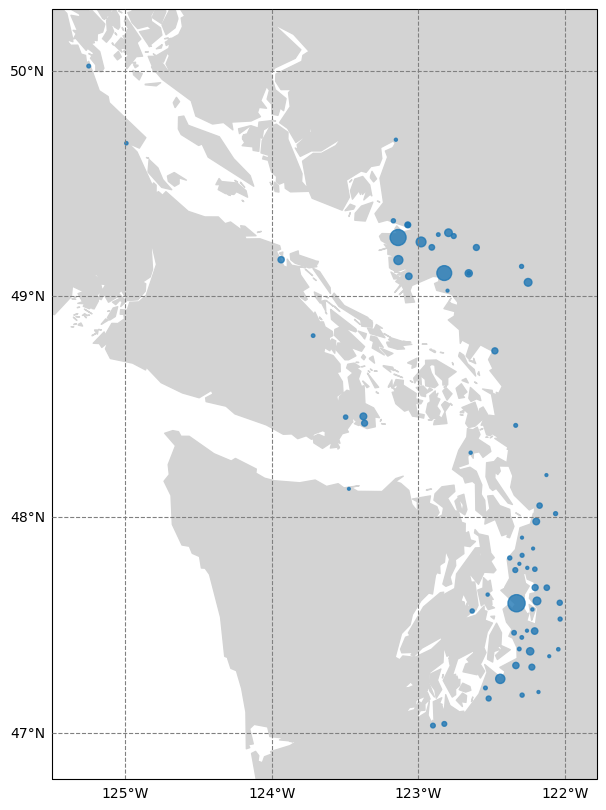

In [55]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+0.25
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='lightgray',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)

In [56]:
import xarray as xr
from salishsea_tools import river_201702 as Rivers
rivers = Rivers.prop_dict
bathy = xr.open_dataset('~/MOAD/grid/grid/bathymetry_201702.nc')
#bathy = xr.open_dataset('~/MOAD/SSC_masks/bathymetry_201702.nc')

In [57]:
River_Name = []
River_Watershed = []
Latitude = []
Longitude = []
for watershed in (rivers.keys()):
    for name in rivers[watershed].keys():
        River_Name.append(name)
        River_Watershed.append(watershed)
        Latitude.append(bathy.nav_lat[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
        Longitude.append(bathy.nav_lon[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
d = {'Name': River_Name, 'Watershed':River_Watershed,'Latitude':Latitude,'Longitude':Longitude}
Rivers_list = pd.DataFrame(data=d)

In [58]:
#fixing main branch Fraser River Location
Rivers_list.iloc[93].Latitude = 49.116204 
Rivers_list.iloc[93].Longitude = -123.189394

#Add runoff location Victoria harbor area
new_row = pd.DataFrame({'Name':'Victoria Harbor','Watershed':'jdf','Latitude':48.416950,'Longitude': -123.395355}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location Victoria Oak Bay
new_row = pd.DataFrame({'Name':'Victoria Oak Bay','Watershed':'jdf','Latitude':48.431265,'Longitude': -123.299794}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location north branch fraser river
new_row = pd.DataFrame({'Name':'Fraser North','Watershed':'fraser','Latitude':49.227044,'Longitude': -123.219523}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location Oak Harbor
new_row = pd.DataFrame({'Name':'Oak Harbor','Watershed':'skagit','Latitude':48.266780,'Longitude': -122.643507}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location Edmonds ferry terminal
new_row = pd.DataFrame({'Name':'Edmonds port','Watershed':'puget','Latitude':47.815885,'Longitude': -122.385012}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

In [59]:
colors_wsheds= {
'howe':'#F6D1BF', 
'jdf':'#AAA67E', 
'puget':'#FCF7B4',
'skagit':'#ACC752', 
'fraser':'#C0DCD1', 
'evi_n':'#B2C391', 
'jervis':'#CFCAD1', 
'toba':'#949B9D', 
'bute':'#AAD3E8', 
'evi_s':'#F0DCB4'}
cc = []
for i in range(Rivers_list.shape[0]):
    cc.append(colors_wsheds[Rivers_list.Watershed.iloc[i]])

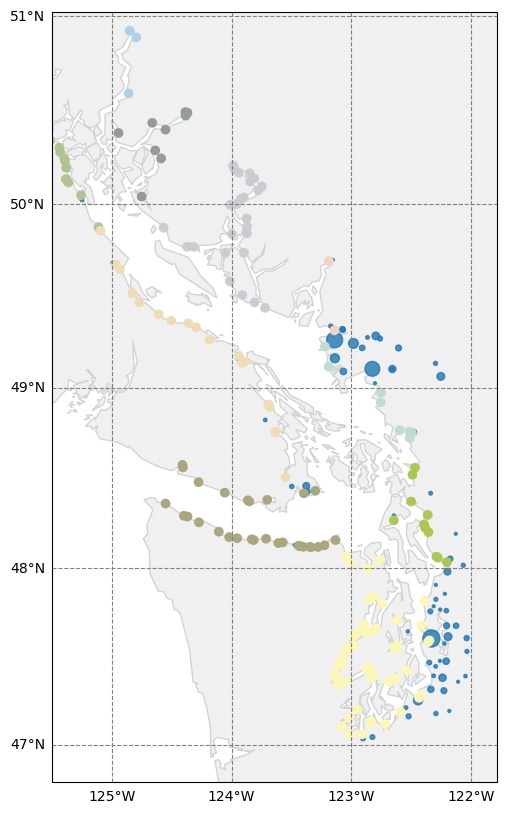

In [60]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)
riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=2,c = cc)

In [61]:
Wclass= {
'howe':1, 
'jdf':2, 
'puget':3,
'skagit':4, 
'fraser':5, 
'evi_n':6, 
'jervis':7, 
'toba':8, 
'bute':9, 
'evi_s':10}
cclas = []
for i in range(Rivers_list.shape[0]):
    cclas.append(Wclass[Rivers_list.Watershed.iloc[i]])

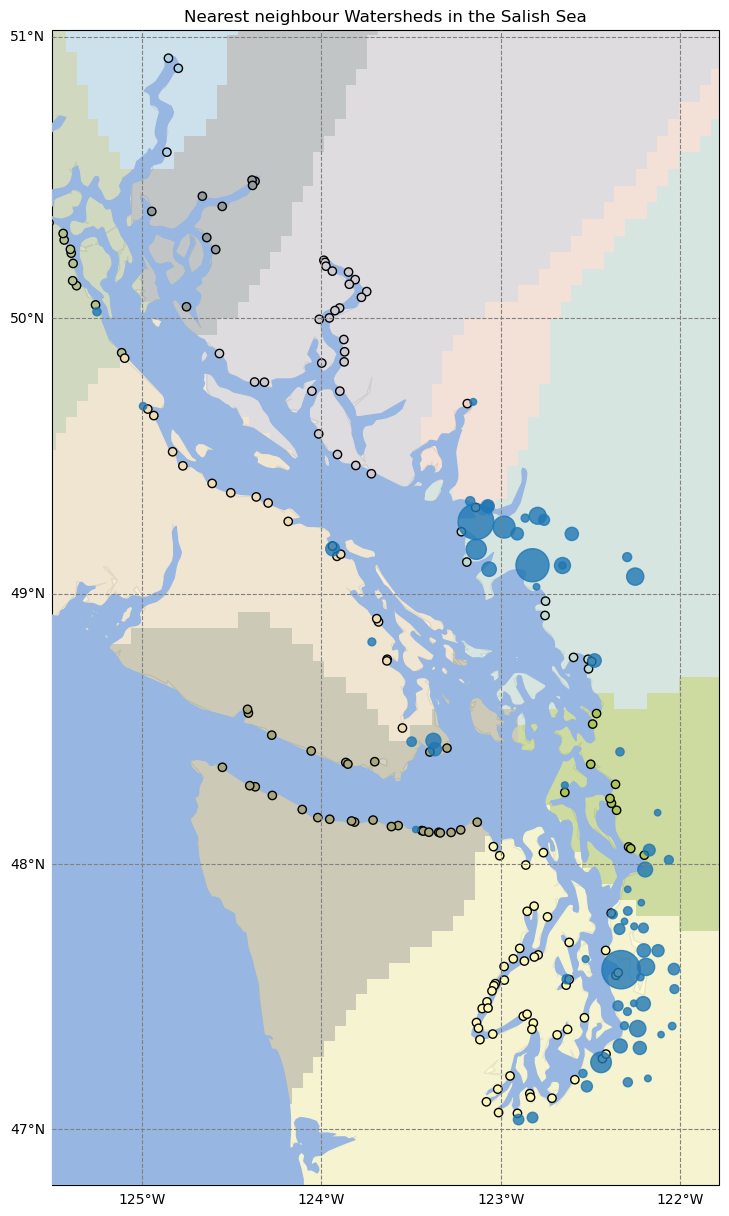

In [62]:
import matplotlib.pyplot as plt
#import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

#keys = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
Rivers_list = Rivers_list[['Name','Watershed','Longitude','Latitude']]
n_neighbors = 5

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = Rivers_list.iloc[:,2:4]
y = cclas

# Create color maps
cmap_light = ListedColormap(['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4'])
cmap_bold = ['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4']

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
clf.fit(X, y)

lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
ax.add_feature(feature.OCEAN,zorder=3)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel='Latitude',
    ylabel='Longitude',
    alpha=0.5,
    transform=crs.PlateCarree()
)
#plt.gca().invert_yaxis()
# Plot also the training points
cit=plt.scatter(Urban.Longitude,Urban.Latitude,zorder=5,alpha=0.8,s=Urban.Population/1e3,transform=crs.PlateCarree())
riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=4,c = cc,edgecolors='k')
plt.title('Nearest neighbour Watersheds in the Salish Sea')
plt.show()

In [63]:
puget = Rivers_list[Rivers_list.Watershed=='puget']
puget = puget[puget.Longitude > -122.5]

In [64]:
puget

,Name,Watershed,Longitude,Latitude
0,Edmonds port,puget,-122.385012,47.815885
77,Puyallup,puget,-122.43389129638672,47.26699447631836
78,Hylebas,puget,-122.41390228271484,47.28432083129883
79,Duwamish1,puget,-122.35884094238281,47.58230972290039
80,Duwamish2,puget,-122.34629821777344,47.591957092285156
81,CedarSammamish,puget,-122.41584777832031,47.675682067871094


In [65]:
Rivers_list = Rivers_list[['Name','Watershed','Latitude','Longitude']]

In [66]:
#fix
def River_dist(City,river_list=Rivers_list):
    rivers_loc = river_list.iloc[:,2:]
    city_loc = City[2:]
    dist_2 = np.sum((rivers_loc - city_loc)**2, axis=1)

    #dist_check = dist_2-dist_2[np.argmin(dist_2)]
    #dist_check = 100*dist_check/dist_2[np.argmin(dist_2)]
    #dist_check[np.argmin(dist_2)] = 1e6
    #if np.min(dist_check) > 5:
    return np.argmin(dist_2)
    #else:
    #    return [np.argmin(dist_2),np.argmin(dist_check)]
Lat_riv = []
Lon_riv = []
for i in range(Urban.shape[0]):
    try:
        Lat_riv.append(np.ndarray.item(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),2]))
        Lon_riv.append(np.ndarray.item(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),3]))
    except TypeError:
        Lat_riv.append(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),2])
        Lon_riv.append(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),3])

In [67]:
Urban['Latitude closest_river'] = Lat_riv
Urban['Longitude closest_river'] = Lon_riv

In [68]:
list(Rivers_list.Name)

['Edmonds port',
 'Oak Harbor',
 'Fraser North',
 'Victoria Oak Bay',
 'Victoria Harbor',
 'Squamish',
 'Burrard',
 'SanJuan',
 'Gordon',
 'Loss',
 'Jordan',
 'Muir',
 'Tugwell',
 'Sooke',
 'Elwha',
 'Tumwater',
 'Valley',
 'Ennis',
 'Morse',
 'Bagley',
 'Siebert',
 'McDonald',
 'DungenessMatriotti',
 'Coville',
 'Salt',
 'Field',
 'Lyre',
 'EastWestTwin',
 'Deep',
 'Pysht',
 'Clallom',
 'Hoko',
 'Sekiu',
 'Sail',
 'Johnson',
 'Jimmycomelately',
 'SalmonSnow',
 'Chimacum',
 'Thorndike',
 'Torboo',
 'LittleBigQuilcene',
 'Dosewalips',
 'Duckabush',
 'Fulton',
 'Waketick',
 'HammaHamma',
 'Jorsted',
 'Eagle',
 'Lilliwaup',
 'Finch',
 'Skokomish',
 'Rendsland',
 'Tahuya',
 'Mission',
 'Union',
 'Coulter',
 'Minter',
 'Burley',
 'Olalla',
 'Blackjack',
 'ClearBarker',
 'BigValley',
 'BigBear',
 'Swaback',
 'Stavis',
 'Anderson',
 'Dewatta',
 'Sherwood',
 'DeerJohnsGoldboroughMill',
 'Skookum',
 'KennedySchneider',
 'PerryMcClane',
 'Deschutes',
 'Woodward',
 'Woodland',
 'Chambers',
 'Nisq

In [69]:
%matplotlib inline
def check_closestriver(n):
    n_neighbors = 5
    # we only take the first two features. We could avoid this ugly
    # slicing by using a two-dim dataset
    X = Rivers_list.iloc[:,2:4]
    y = cclas

    # Create color maps
    cmap_light = ListedColormap(['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4'])
    cmap_bold = ['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4']

    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
    clf.fit(X, y)

    lonmin= Urban.Longitude.min()-0.25
    lonmax= Urban.Longitude.max()+0.25
    latmin= Urban.Latitude.min()-0.25
    latmax= Urban.Latitude.max()+1
    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': crs.Mercator()})
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
    ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
    ax.add_feature(feature.OCEAN,zorder=3)
    gl = ax.gridlines(
        linestyle='--', color='gray', draw_labels=True,
        xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
    gl.top_labels, gl.right_labels = False, False
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel='Latitude',
        ylabel='Longitude',
        alpha=0.5,
        transform=crs.PlateCarree()
    )
    # Plot also the training points
    cit=plt.scatter(Urban.Longitude,Urban.Latitude,zorder=5,alpha=0.8,s=Urban.Population/1e3,transform=crs.PlateCarree())
    riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=4,c = cc,edgecolors='k')
    plt.title(Urban.Name.iloc[n])

    cit=plt.scatter(Urban.Longitude.iloc[n],Urban.Latitude.iloc[n],zorder=6,transform=crs.PlateCarree(),c = 'r')
    cit=plt.scatter(Urban['Longitude closest_river'].iloc[n],Urban['Latitude closest_river'].iloc[n],zorder=6,transform=crs.PlateCarree(),c = 'k')

    plt.show()

#check_closestriver(41)

In [70]:
def fix_rivers(n,rivername):
    try:
        for ni in n:
            Urban.iat[ni,4] = Rivers_list[Rivers_list.Name == rivername].iat[0,2]
            Urban.iat[ni,5] = Rivers_list[Rivers_list.Name == rivername].iat[0,3]
    except TypeError:
        Urban.iat[n,4] = Rivers_list[Rivers_list.Name == rivername].iat[0,2]
        Urban.iat[n,5] = Rivers_list[Rivers_list.Name == rivername].iat[0,3]
    return 

In [71]:
fix_rivers([0,1,3,8,9,11,13,16],'Fraser')
fix_rivers([6,18],'Victoria Harbor')
fix_rivers(21,'Cowichan1')
fix_rivers(26,'Stillaguamish1')
fix_rivers([35,42],'Duwamish1')
fix_rivers(52,'Skagit1')
fix_rivers([47,32,41,51,53,54],'CedarSammamish')

In [72]:
Urban[Urban['Latitude closest_river']== Rivers_list[Rivers_list.Name == 'Edmonds port'].iat[0,2]]

,Name,Population,Latitude,Longitude,Latitude closest_river,Longitude closest_river
198,Edmonds,42980,47.811619,-122.376640,47.815885,-122.385012
657,Shoreline,60320,47.755985,-122.338928,47.815885,-122.385012


In [73]:
def Population_by_river(rivername):
    return np.sum(Urban[Urban['Latitude closest_river']== Rivers_list[Rivers_list.Name == rivername].iat[0,2]].Population)
Population_by_river('Fraser')/10000

171.0911

In [74]:
popriv = []
for river in list(Rivers_list.Name):
    popriv.append(Population_by_river(river))
Rivers_list['Population_polluting'] = popriv

In [75]:
Rivers_deploy = Rivers_list[Rivers_list.Population_polluting > popmin]

In [76]:
Rivers_deploy.to_csv('Deploy_locations.csv')

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from math import ceil,sin,cos, atan2, pi, sqrt
import pandas as pd
from cartopy import crs, feature
import requests
from bs4 import BeautifulSoup
Rivers_deploy = pd.read_csv('Deploy_locations.csv', index_col = [0])

In [78]:
Rivers_deploy.sort_values(by = 'Population_polluting',ascending = False)

,Name,Watershed,Latitude,Longitude,Population_polluting
98,Fraser,fraser,49.116204,-123.189394,1710911
80,Duwamish2,puget,47.591957,-122.346298,1379160
6,Burrard,howe,49.315445,-123.139832,886193
78,Hylebas,puget,47.284321,-122.413902,289960
4,Victoria Harbor,jdf,48.416950,-123.395355,256186
79,Duwamish1,puget,47.582310,-122.358841,243500
89,SnohomishAllenQuilceda,skagit,48.032848,-122.200569,226380
77,Puyallup,puget,47.266994,-122.433891,220800
92,Dakota,fraser,48.973057,-122.750824,183505
81,CedarSammamish,puget,47.675682,-122.415848,176940


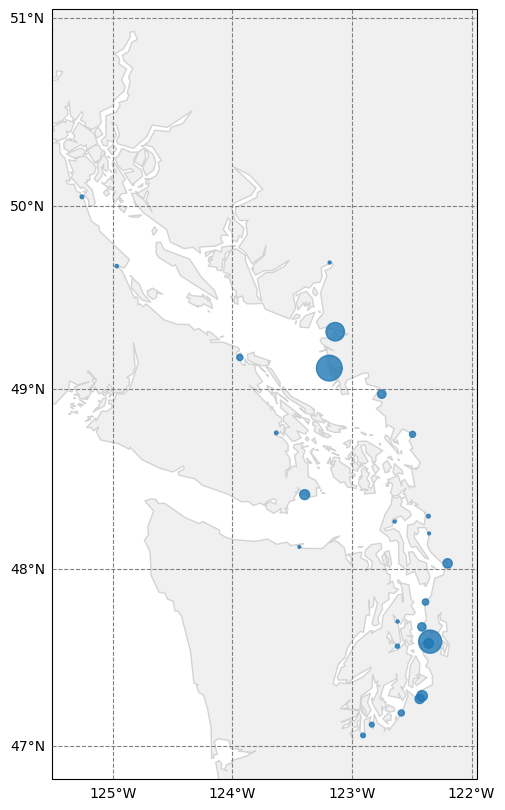

In [79]:
lonmin= Rivers_deploy.Longitude.min()-0.25
lonmax= Rivers_deploy.Longitude.max()+0.25
latmin= Rivers_deploy.Latitude.min()-0.25
latmax= Rivers_deploy.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Rivers_deploy.Longitude,Rivers_deploy.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Rivers_deploy.Population_polluting/5e3)